### Import Libraries

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Available!" )
else:
    raise Exception("No GPU available") 

GPU is Available!


### Hyperparameters

In [5]:
BATCH_SIZE = 32
DROPOUT_RATE = 0.5
ACTIVATION_FUNCTION = 'softmax'
LEARNING_RATE = 1e-4
LOSS_FUNCTION = 'categorical_crossentropy'

### Data Processing and Augmentation

In [6]:
# Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224  # ResNet-50 input size

# Define data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# No augmentation for validation and test sets, only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    '../../dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '../../dataset/validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '../../dataset/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 958941 images belonging to 27 classes.
Found 19860 images belonging to 27 classes.
Found 49500 images belonging to 27 classes.


### Load Pretrained ResNet-50 Model

Potential to experiment with other pretrained ResNet models from Keras. OPtions currently offerred are:

| Model | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | Time (ms) per inference step (CPU) | Time (ms) per inference step (GPU) |
| --- | --- | --- | --- | --- | --- | --- | --- |
| ResNet50    |	98  | 74.9% | 92.1% | 25.6M | 107 |	58.2 |	4.6 |
| ResNet50V2  |	98  | 76.0% | 93.0% | 25.6M | 103 |	45.6 |	4.4 |
| ResNet101   |	171 | 76.4% | 92.8% | 44.7M | 209 |	89.6 |	5.2 |
| ResNet101V2 |	171 | 77.2% | 93.8% | 44.7M | 205 |	72.7 |	5.4 |
| ResNet152   |	232 | 76.6%	| 93.1%	| 60.4M	| 311 | 127.4|	6.5 |

Deeper models are recommended when one has access to more computational resources and larger datasets.

In [7]:
# Load the ResNet-50 model without the top classification layer
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    include_top=False,   # Do not include the ImageNet classifier at the top
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)


94765736/94765736 [==============================] - 1s 0us/step


### Customize Model for Classification

In [8]:
# Freeze the base model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT_RATE)(x)  # Regularization
outputs = layers.Dense(train_generator.num_classes, activation=ACTIVATION_FUNCTION)(x)
model = keras.Model(inputs, outputs)


### Compile Model

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=LOSS_FUNCTION,
    metrics=['accuracy']
)


### Train the Model

In [10]:
# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, restore_best_weights=True
    )
]

In [11]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/10
29967/29967 [==============================] - 7438s 248ms/step - loss: 2.7801 - accuracy: 0.1575 - val_loss: 3.3501 - val_accuracy: 0.1218
Epoch 2/10
29967/29967 [==============================] - 7226s 241ms/step - loss: 2.6596 - accuracy: 0.1942 - val_loss: 3.3247 - val_accuracy: 0.1242
Epoch 3/10
29967/29967 [==============================] - 7293s 243ms/step - loss: 2.6155 - accuracy: 0.2067 - val_loss: 3.2881 - val_accuracy: 0.1393
Epoch 4/10
29967/29967 [==============================] - 7482s 250ms/step - loss: 2.5862 - accuracy: 0.2152 - val_loss: 3.2602 - val_accuracy: 0.1502
Epoch 5/10
29967/29967 [==============================] - 7538s 252ms/step - loss: 2.5654 - accuracy: 0.2207 - val_loss: 3.2293 - val_accuracy: 0.1390
Epoch 6/10
29967/29967 [==============================] - 7327s 244ms/step - loss: 2.5479 - accuracy: 0.2256 - val_loss: 3.2101 - val_accuracy: 0.1545
Epoch 7/10
29967/29967 [==============================] - 7294s 243ms/step - loss: 2.5356 - ac

### Resume Training

In [12]:
# model = keras.models.load_model('best_model.h5')

### Unfreeze Some Layers for Fine-Tuning

In [13]:
# Unfreeze the top layers of the model
base_model.trainable = True

# Freeze all layers except the last few layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/10
29967/29967 [==============================] - 7192s 240ms/step - loss: 2.2186 - accuracy: 0.3148 - val_loss: 2.9194 - val_accuracy: 0.2114
Epoch 2/10
29967/29967 [==============================] - 7346s 245ms/step - loss: 2.0737 - accuracy: 0.3591 - val_loss: 2.9795 - val_accuracy: 0.2235
Epoch 3/10
29967/29967 [==============================] - 7345s 245ms/step - loss: 1.9989 - accuracy: 0.3813 - val_loss: 2.9036 - val_accuracy: 0.2277
Epoch 4/10
29967/29967 [==============================] - 7390s 247ms/step - loss: 1.9428 - accuracy: 0.3977 - val_loss: 2.7314 - val_accuracy: 0.2637
Epoch 5/10
29967/29967 [==============================] - 7315s 244ms/step - loss: 1.8962 - accuracy: 0.4109 - val_loss: 2.7850 - val_accuracy: 0.2525
Epoch 6/10
29967/29967 [==============================] - 7678s 256ms/step - loss: 1.8558 - accuracy: 0.4230 - val_loss: 2.6386 - val_accuracy: 0.2676
Epoch 7/10
29967/29967 [==============================] - 7539s 252ms/step - loss: 1.8221 - ac

### Evaluate the Model

In [14]:
# Load the best model
model = keras.models.load_model('best_model.h5')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.2f}')

# Generate classification report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))


1547/1547 [==============================] - 248s 160ms/step - loss: 2.2503 - accuracy: 0.3453
Test accuracy: 0.35
1547/1547 [==============================] - 97s 62ms/step
Classification Report
                             precision    recall  f1-score   support

            dry-asphalt-bad       0.63      0.04      0.08       800
           dry-asphalt-good       0.24      0.45      0.32      2350
   dry-asphalt-intermediate       0.31      0.36      0.33      2350
           dry-concrete-bad       0.35      0.60      0.45      2350
          dry-concrete-good       0.43      0.48      0.45      2350
  dry-concrete-intermediate       0.54      0.09      0.15      2350
                 dry-gravel       0.22      0.61      0.33      2350
                    dry-mud       0.23      0.50      0.31      2350
                 fresh_snow       0.56      0.57      0.56      2350
                        ice       0.45      0.40      0.42      2350
                melted_snow       0.71      

d:\Projects\ResNet-FineTune-Project\env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\ResNet-FineTune-Project\env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\ResNet-FineTune-Project\env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

### VIsualize Training Results

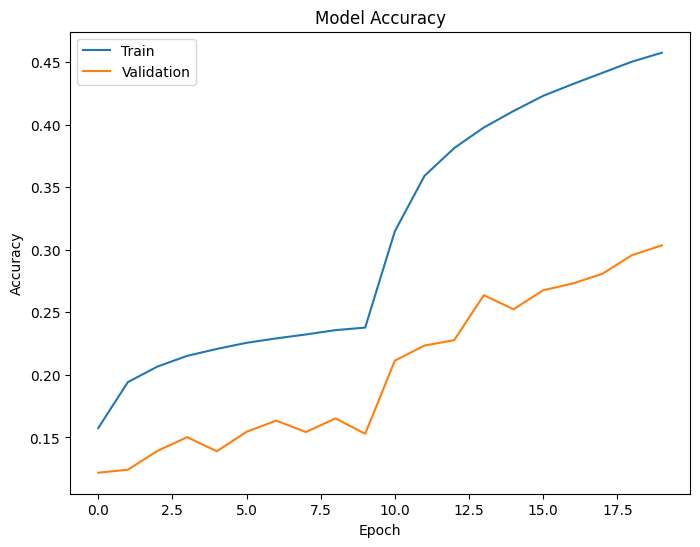

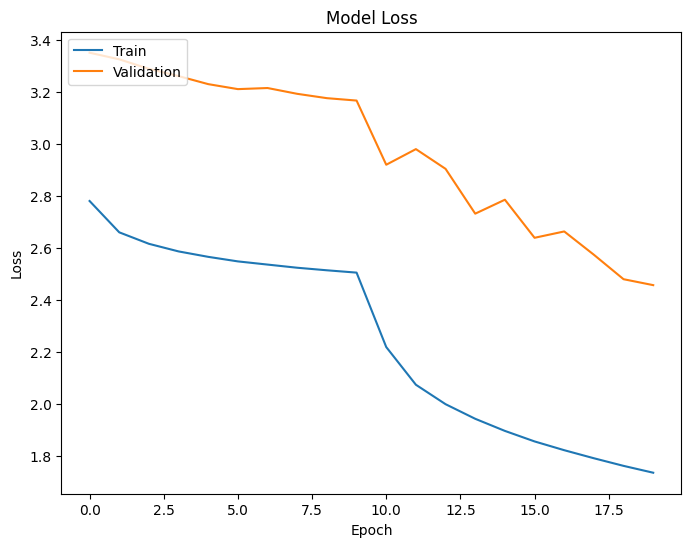

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Save Trained Model

In [16]:
# Save the trained model for future use
model.save('road_surface_classifier.h5')
